In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  #畫圖形
import math
from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

C:\Users\joyle\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def sort_data(Data):
    d = Data["Date"]
    d = pd.to_datetime(d)

    data = Data["Price"]
    data.index = pd.Index(d)

    return data

def missing_value():
    SAT = pd.date_range(start = '01/01/2016', end = '03/31/2019', freq='W-SAT')

    SUN = pd.date_range(start = '01/01/2016', end = '05/31/2018', freq='W-SUN')

    s1 = pd.Series([np.nan]*len(SAT) ,index=SAT)
    s2 = pd.Series([np.nan]*len(SUN) ,index=SUN)
    
    return s1, s2
    
def supplement_data(data):
    s1, s2 = missing_value()
    
    data = data.append(s1)
    data = data.append(s2)
    
    data.sort_index(inplace=True)
    
    for j in range(len(data)):
        null_value = data[data.isnull().values == True]
        if len(null_value) != 0:
            for i in range(len(null_value)):
                if math.isnan(data[null_value.index[i]+timedelta(-1)]) == False:
                    if math.isnan(data[null_value.index[i]+timedelta(1)]) == False: 
                        data[null_value.index[i]] = (data[null_value.index[i]+timedelta(-1)]+data[null_value.index[i]+timedelta(1)])/2
            data = data.fillna(method = 'ffill', limit = 1)
            data = data.fillna(method = 'bfill', limit = 1)            
        else:
            break
    
            
    return data

def split(data):
    train = data[:'2018-12-31']    
    true = data['2019-01-01':]
    test = data['2018-12-25':]
    
    return train, true, test

def train_data(train):
    x_train = []
    y_train = []
    for i in range(7, len(train)):
        x_train.append(train[i-7:i])
        y_train.append(train[i])
    x_train, y_train = np.array(x_train), np.array(y_train)

    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train

def model(x_train, y_train):
    model = Sequential()    
    model.add(Dense(50, input_dim = x_train.shape[1], activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    train_history = model.fit(x_train, y_train, epochs = 1000, batch_size = 200, validation_split=0.2)
    
    return model, train_history

def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
def predict(test):
    x_test = []
    for i in range(7, len(test)):
        x_test.append(test[i-7:i])
    x_test = np.array(x_test)

    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    predicted_data = model.predict(x_test)
    
    predicted_data = predicted_data.ravel() #拉成一維
    predicted_data = pd.Series(predicted_data)
    
    #預測的日期
    pred_time = pd.date_range(start = '01/01/2019', end = '03/31/2019')
        
    predicted_data.index = pd.Index(pred_time)
    predicted_data = pd.DataFrame(predicted_data , columns=['現金'])
    
    return predicted_data

def plot_data(true_data, predicted_data):
    plt.figure(figsize=(12,6))
    plt.plot(predicted_data.index, true_data, color = 'cornflowerblue', marker = 'o', label='True')
    plt.plot(predicted_data.index, predicted_data, color = 'lightcoral', marker = 'o', label='Predict')
    plt.legend()
    plt.show()
def rmse(test, true):
    predicted_data = predict(test)
    
    #drop value
    SAT = pd.date_range(start = '01/01/2019', end = '03/31/2019', freq='W-SAT')
    
    predicted_data = predicted_data.drop(SAT)
    
    true = true.drop(SAT)
    true = pd.DataFrame(true , columns=['現金'])
    
    RMSE = np.sqrt(((predicted_data-true)**2).sum()/true.size)
    MAPE = abs((true-predicted_data)/true).sum()/len(true)
    
    return RMSE, MAPE, predicted_data , true


In [4]:
Data = pd.read_excel("c:/python/AUD-USD/AUD_USD.xlsx",index_col=False)
data = sort_data(Data)
data = supplement_data(data)
train, true, test = split(data)
x_train , y_train = train_data(train)

In [5]:
start = time.time()

In [6]:
model, train_history = model(x_train , y_train)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 871 samples, validate on 218 samples
Epoch 1/1000
871/871 [==============================] - 0s 123us/step - loss: 0.0686 - val_loss: 0.0255
Epoch 2/1000
871/871 [==============================] - 0s 13us/step - loss: 0.0161 - val_loss: 0.0012
Epoch 3/1000
871/871 [==============================] - 0s 12us/step - loss: 7.0498e-04 - val_loss: 0.0029
Epoch 4/1000
871/871 [==============================] - 0s 13us/step - loss: 0.0045 - val_loss: 0.0063
Epoch 5/1000
871/871 [==============================] - 0s 14us/step - loss: 0.0056 - val_loss: 0.0034
Epoch 6/1000
871/871 [==============================] - 0s 10us/step - loss: 0.0020 - val_loss: 3.4971e-04
Epoch 7/1000
871/871 [==============================] - 0s 12us/step - loss: 1.3335e-04 - val_loss: 2.3930e-04
Epoch 8/1000
871/871 [==============================] - 0s 14us/step - loss: 5.9804e-04 - val_loss: 6.5894e-04
Epoch 9/1000
871/871 [==========

871/871 [==============================] - 0s 11us/step - loss: 3.4137e-05 - val_loss: 3.4850e-05
Epoch 145/1000
871/871 [==============================] - 0s 10us/step - loss: 3.4141e-05 - val_loss: 3.4485e-05
Epoch 146/1000
871/871 [==============================] - 0s 10us/step - loss: 3.4139e-05 - val_loss: 3.5489e-05
Epoch 147/1000
871/871 [==============================] - 0s 11us/step - loss: 3.4144e-05 - val_loss: 3.4519e-05
Epoch 148/1000
871/871 [==============================] - 0s 14us/step - loss: 3.4159e-05 - val_loss: 3.4374e-05
Epoch 149/1000
871/871 [==============================] - 0s 9us/step - loss: 3.4102e-05 - val_loss: 3.5117e-05
Epoch 150/1000
871/871 [==============================] - 0s 10us/step - loss: 3.4105e-05 - val_loss: 3.5560e-05
Epoch 151/1000
871/871 [==============================] - 0s 9us/step - loss: 3.4192e-05 - val_loss: 3.5081e-05
Epoch 152/1000
871/871 [==============================] - 0s 11us/step - loss: 3.4052e-05 - val_loss: 3.2668e-05


Epoch 217/1000
871/871 [==============================] - 0s 12us/step - loss: 3.3919e-05 - val_loss: 3.3317e-05
Epoch 218/1000
871/871 [==============================] - 0s 10us/step - loss: 3.3946e-05 - val_loss: 3.4830e-05
Epoch 219/1000
871/871 [==============================] - 0s 9us/step - loss: 3.3878e-05 - val_loss: 3.3868e-05
Epoch 220/1000
871/871 [==============================] - 0s 11us/step - loss: 3.4044e-05 - val_loss: 3.4268e-05
Epoch 221/1000
871/871 [==============================] - 0s 9us/step - loss: 3.4019e-05 - val_loss: 3.6453e-05
Epoch 222/1000
871/871 [==============================] - 0s 10us/step - loss: 3.3922e-05 - val_loss: 3.3037e-05
Epoch 223/1000
871/871 [==============================] - 0s 9us/step - loss: 3.3929e-05 - val_loss: 3.4206e-05
Epoch 224/1000
871/871 [==============================] - 0s 10us/step - loss: 3.4019e-05 - val_loss: 3.4979e-05
Epoch 225/1000
871/871 [==============================] - 0s 9us/step - loss: 3.3971e-05 - val_loss

Epoch 290/1000
871/871 [==============================] - 0s 10us/step - loss: 3.4034e-05 - val_loss: 3.3876e-05
Epoch 291/1000
871/871 [==============================] - 0s 10us/step - loss: 3.3817e-05 - val_loss: 3.4294e-05
Epoch 292/1000
871/871 [==============================] - 0s 12us/step - loss: 3.4006e-05 - val_loss: 3.2788e-05
Epoch 293/1000
871/871 [==============================] - 0s 9us/step - loss: 3.3582e-05 - val_loss: 3.7937e-05
Epoch 294/1000
871/871 [==============================] - 0s 9us/step - loss: 3.3966e-05 - val_loss: 3.3053e-05
Epoch 295/1000
871/871 [==============================] - 0s 10us/step - loss: 3.3580e-05 - val_loss: 3.4445e-05
Epoch 296/1000
871/871 [==============================] - 0s 10us/step - loss: 3.3748e-05 - val_loss: 3.3355e-05
Epoch 297/1000
871/871 [==============================] - 0s 8us/step - loss: 3.3926e-05 - val_loss: 3.2765e-05
Epoch 298/1000
871/871 [==============================] - 0s 10us/step - loss: 3.3895e-05 - val_los

Epoch 435/1000
871/871 [==============================] - 0s 9us/step - loss: 3.2788e-05 - val_loss: 3.1978e-05
Epoch 436/1000
871/871 [==============================] - 0s 8us/step - loss: 3.2859e-05 - val_loss: 3.5258e-05
Epoch 437/1000
871/871 [==============================] - 0s 10us/step - loss: 3.3076e-05 - val_loss: 3.0108e-05
Epoch 438/1000
871/871 [==============================] - 0s 10us/step - loss: 3.3459e-05 - val_loss: 3.4702e-05
Epoch 439/1000
871/871 [==============================] - 0s 10us/step - loss: 3.3272e-05 - val_loss: 3.1204e-05
Epoch 440/1000
871/871 [==============================] - 0s 9us/step - loss: 3.2845e-05 - val_loss: 3.3167e-05
Epoch 441/1000
871/871 [==============================] - 0s 12us/step - loss: 3.2797e-05 - val_loss: 3.3011e-05
Epoch 442/1000
871/871 [==============================] - 0s 9us/step - loss: 3.2753e-05 - val_loss: 3.2749e-05
Epoch 443/1000
871/871 [==============================] - 0s 12us/step - loss: 3.2728e-05 - val_loss

Epoch 580/1000
871/871 [==============================] - 0s 10us/step - loss: 3.1823e-05 - val_loss: 3.0215e-05
Epoch 581/1000
871/871 [==============================] - 0s 9us/step - loss: 3.1625e-05 - val_loss: 3.3240e-05
Epoch 582/1000
871/871 [==============================] - 0s 11us/step - loss: 3.1780e-05 - val_loss: 2.9861e-05
Epoch 583/1000
871/871 [==============================] - 0s 8us/step - loss: 3.1955e-05 - val_loss: 3.0047e-05
Epoch 584/1000
871/871 [==============================] - 0s 9us/step - loss: 3.2540e-05 - val_loss: 3.5524e-05
Epoch 585/1000
871/871 [==============================] - 0s 10us/step - loss: 3.1971e-05 - val_loss: 2.9958e-05
Epoch 586/1000
871/871 [==============================] - 0s 9us/step - loss: 3.1603e-05 - val_loss: 3.4412e-05
Epoch 587/1000
871/871 [==============================] - 0s 10us/step - loss: 3.1916e-05 - val_loss: 3.0501e-05
Epoch 588/1000
871/871 [==============================] - 0s 10us/step - loss: 3.1853e-05 - val_loss

Epoch 725/1000
871/871 [==============================] - 0s 10us/step - loss: 3.0336e-05 - val_loss: 2.7993e-05
Epoch 726/1000
871/871 [==============================] - 0s 10us/step - loss: 3.0438e-05 - val_loss: 3.4380e-05
Epoch 727/1000
871/871 [==============================] - 0s 9us/step - loss: 3.0749e-05 - val_loss: 2.8634e-05
Epoch 728/1000
871/871 [==============================] - 0s 9us/step - loss: 3.1316e-05 - val_loss: 2.6338e-05
Epoch 729/1000
871/871 [==============================] - 0s 10us/step - loss: 3.0697e-05 - val_loss: 3.2509e-05
Epoch 730/1000
871/871 [==============================] - 0s 9us/step - loss: 3.0843e-05 - val_loss: 3.6071e-05
Epoch 731/1000
871/871 [==============================] - 0s 10us/step - loss: 3.1921e-05 - val_loss: 2.8136e-05
Epoch 732/1000
871/871 [==============================] - 0s 9us/step - loss: 3.1813e-05 - val_loss: 2.5839e-05
Epoch 733/1000
871/871 [==============================] - 0s 9us/step - loss: 3.1208e-05 - val_loss:

Epoch 870/1000
871/871 [==============================] - 0s 10us/step - loss: 2.9404e-05 - val_loss: 2.6158e-05
Epoch 871/1000
871/871 [==============================] - 0s 10us/step - loss: 2.9120e-05 - val_loss: 2.6564e-05
Epoch 872/1000
871/871 [==============================] - 0s 10us/step - loss: 2.8818e-05 - val_loss: 2.8228e-05
Epoch 873/1000
871/871 [==============================] - 0s 8us/step - loss: 2.8932e-05 - val_loss: 2.5509e-05
Epoch 874/1000
871/871 [==============================] - 0s 9us/step - loss: 2.8807e-05 - val_loss: 2.5991e-05
Epoch 875/1000
871/871 [==============================] - 0s 10us/step - loss: 2.8880e-05 - val_loss: 2.4228e-05
Epoch 876/1000
871/871 [==============================] - 0s 10us/step - loss: 3.1066e-05 - val_loss: 2.4259e-05
Epoch 877/1000
871/871 [==============================] - 0s 9us/step - loss: 3.1645e-05 - val_loss: 3.1502e-05
Epoch 878/1000
871/871 [==============================] - 0s 10us/step - loss: 3.1775e-05 - val_los

In [7]:
end = time.time()
running_time = end-start
print(running_time)

10.037147045135498


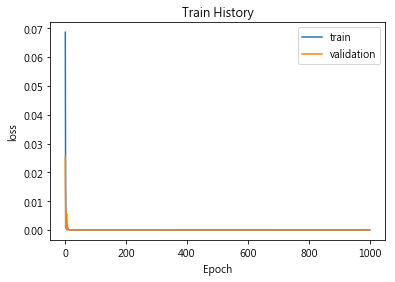

In [8]:
show_train_history(train_history,'loss','val_loss')